In [10]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

In [11]:
# calibrating camera.
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
# chessboard size is 9 x 6.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] 
imgpoints = [] 

# Read chessboard image files.
# these are used to calibrate the camera.
images = glob.glob('camera_cal/calibration*.jpg')

In [12]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cornered_found_file = 'output_images/calibration_camera_images/calibration_with_corners_' + str(idx) + '.jpg'
        cv2.imshow('img', img)
        cv2.imwrite(cornered_found_file, img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

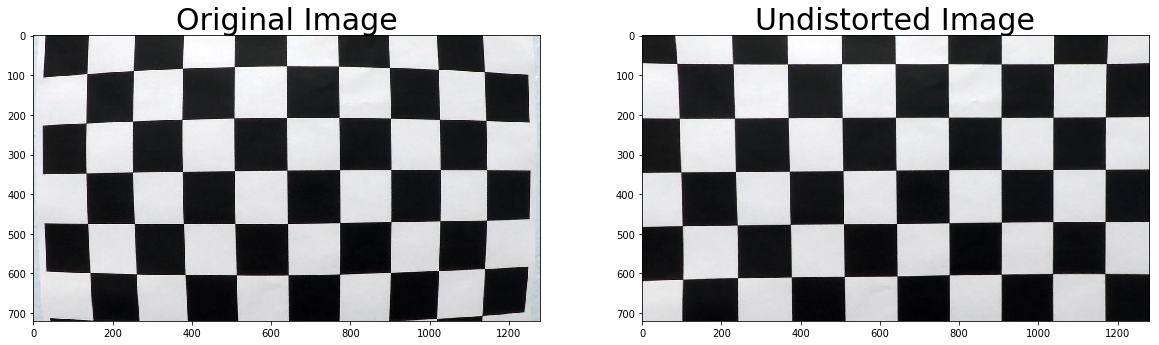

In [13]:
import pickle
%matplotlib inline

# Test undistortion on an image using one of the images, calibration1.jpg
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# save undistorted image.
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undistorted.jpg',dst)

# Save the camera calibration result for later use
# we need to save mtx and dist
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "calibrated/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

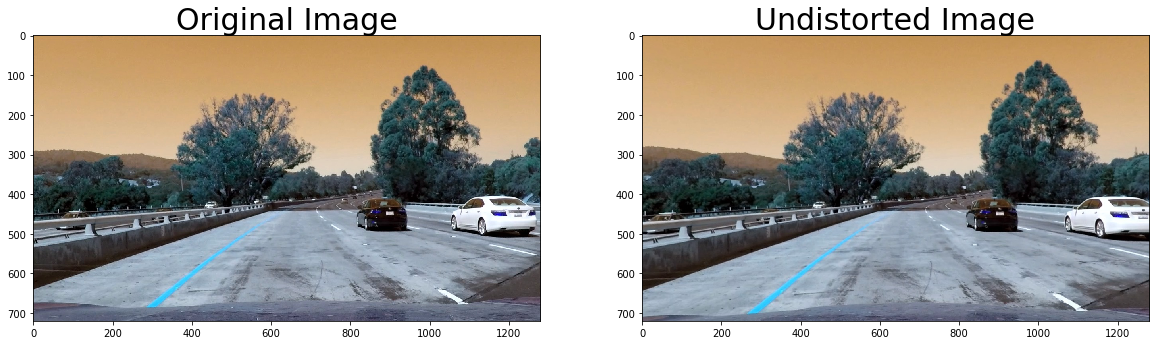

In [14]:
# this is for the test. Will remove this cell later.
# just want to test one image.
# dst is undistorted image.
img = cv2.imread('test_images/test1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test1_undistorted.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

True

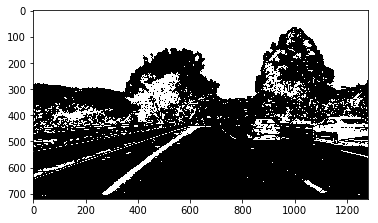

In [84]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # convert it to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else: # orient is 'y'
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def color_thresh(img, sthresh=(0, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
       
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    #plt.imshow(sbinary)
    return sbinary
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    sobel_abs = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    sxbinary = np.zeros_like(grad_dir)
    sxbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    #plt.imshow(sxbinary)
    return sxbinary

combinedImage = np.zeros_like(dst[:,:,0])
combinedImage2 = np.zeros_like(dst[:,:,0])
gradx = abs_sobel_thresh(dst, orient='x', thresh=(12, 255))
#grady = abs_sobel_thresh(dst, orient='y', thresh=(25, 255))
grady = abs_sobel_thresh(dst, orient='y', thresh=(80, 255))
colorbinary = color_thresh(dst, sthresh=(80, 255)) 
# tried mag_binary but it seemed to make the lines thinner.
#mag_binary = mag_thresh(dst, mag_thresh=(150, 255))  
# dir_binary also seems to hinder the line detection, too.
#dir_binary = dir_threshold(dst, thresh=(0.3, 1.5))
#combinedImage[((gradx == 1) & (grady == 1)) | (colorbinary == 1)] = 255
#tried gradx but it doesn't seem to be necessary.  remove gradx.
combinedImage[((grady == 1)) | (colorbinary == 1)] = 255
#combinedImage[((gradx == 1) & (grady == 1)) | (colorbinary == 1)] = 255
plt.imshow(combinedImage, cmap='gray')
binary_image_file = 'output_images/binary_images/binary_image_' + str(idx) + '.jpg'
cv2.imwrite(binary_image_file, combinedImage)

720 1280


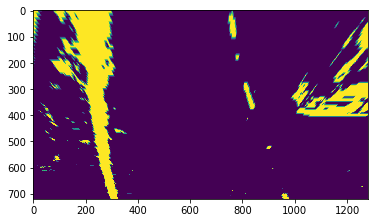

In [87]:
# prespective transformation
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    x_perc_top = 0.48
    x_perc_bot = 0.18
    y_perc_top = 0.63
    y_perc_bot = 0.95
    x_offset = 0.09*img_size[0]  # added x_offset since the camera is not center.
    src = np.float32(
    [[img_size[0]*x_perc_top, img_size[1]*y_perc_top],
    [img_size[0]*x_perc_bot, img_size[1]*y_perc_bot],
    [img_size[0]*(1-x_perc_bot)+x_offset, img_size[1]*y_perc_bot],
    [img_size[0]*(1-x_perc_top)+x_offset, img_size[1]*y_perc_top]]
    )
    
    offset_x = 0.20*img_size[0]  # 0.2 seems to be a good value after playing around.
    destination = np.float32(
    [[offset_x, 0],
    [offset_x, img_size[1]],
    [img_size[0]-offset_x, img_size[1]],
    [img_size[0]-offset_x, 0]]
    )

    M = cv2.getPerspectiveTransform(src, destination) 
    Minv = cv2.getPerspectiveTransform(destination, src)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, Minv

warped, Minv = warp(combinedImage)
plt.imshow(warped)

640


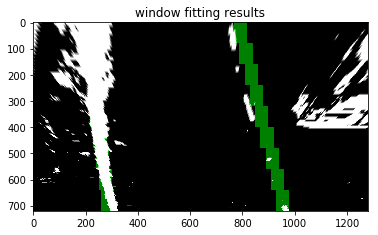

In [97]:
# window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 20# How much to slide left and right for searching
recent_centers =[]

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    leftx = []
    rightx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

ploty = np.arange(warped.shape[0]-(window_height/2),0, window_height)

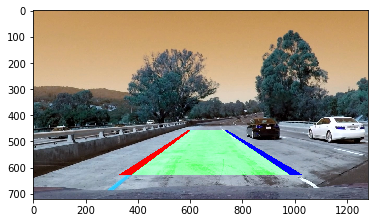

In [66]:
yval_range = range(0, warped.shape[0])
yvals = np.arange(warped.shape[0]-(window_height/2),0, -window_height)
#print(leftx)
#print(rightx)
#print(yvals)
#print(yval_range)
left_fit = np.polyfit(yvals, leftx, 2)  # 2nd degree polynomial
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2] #A*Y^2 + B*Y + C
right_fit = np.polyfit(yvals, rightx, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),
                              axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),
                              axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
middle_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2),
                              axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

road = np.zeros_like(img)
road_bkg = np.zeros_like(img)

cv2.fillPoly(road, [left_lane], color=[255,0,0])
cv2.fillPoly(road, [right_lane], color=[0,0,255])
cv2.fillPoly(road, [middle_lane], color=[0,255,0])
cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
cv2.fillPoly(road_bkg, [right_lane], color=[255,255,255])

road_warped = cv2.warpPerspective(road,Minv,img_size, flags=cv2.INTER_LINEAR)
road_bkg_warped = cv2.warpPerspective(road_bkg,Minv,img_size, flags=cv2.INTER_LINEAR)

bkg = cv2.addWeighted(img, 1.0, road_bkg_warped, -1.0, 0.0)
results = cv2.addWeighted(bkg, 1.0, road_warped, 1.0, 0.0)
plt.imshow(results)
plt.show()


In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(yvals*np.asarray(ym_per_pix), leftx*np.asarray(xm_per_pix), 2)
right_fit_cr = np.polyfit(yvals*np.asarray(ym_per_pix), rightx*np.asarray(xm_per_pix), 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


In [ ]:
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted_file = 'output_images/undistorted_test_images/test_undistorted_' + str(idx) + '.jpg'
    cv2.imwrite(undistorted_file, dst)

In [ ]:
# keep this for now.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # convert it to gray scale
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    if orient == 'x':
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
        #sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    else: # orient is 'y'
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
        #sobel = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    sobel_abs = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    sxbinary = np.zeros_like(grad_dir)
    sxbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    #plt.imshow(sxbinary)
    return sxbinary

image = dst
ksize = 5
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 80))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 155))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 255))


dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.2, 1.3))
combined = np.zeros_like(dir_binary)
#combined[(grady == 1) | ((dir_binary == 1) & (dir_binary == 1)) ] = 1
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#cv2.imwrite('output_images/straight_lines1_combined.png',combined)
fig, (ax) = plt.subplots()
ax.imshow(combined, cmap='gray')


In [ ]:
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y
img = combined

def corners_unwarp(img, nx, ny, mtx, dist):
    #undist = cv2.undistort(img, mtx, dist, None, mtx) 
    #gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY) 
    combined = img
    ret, corners = cv2.findChessboardCorners(combined, (nx,ny), None) 
    if ret == True:
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)
    img_size = (combined.shape[1], combined.shape[0])
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    offset = 100 # offset for dst points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])    
    
    M = cv2.getPerspectiveTransform(src, dst)   
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(top_down)
#ax2.set_title('Undistorted and Warped Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)